In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import pickle
import seaborn as sns


In [2]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
warnings.filterwarnings("ignore")

In [4]:
dataset_path = "../data/demand_supply_data.csv"
df = pd.read_csv(dataset_path)

In [5]:
df.head()

,Date,Category,Product_Name,Demand,Available_Supply,Seasonal_Indicator
0,2021-01-01,Electronics,E001,76,744,0
1,2021-01-01,Fashion,F001,71,579,0
2,2021-01-01,Electronics,E003,94,996,0
3,2021-01-01,Sweets & Grocery,S001,69,761,0
4,2021-01-01,Sweets & Grocery,S004,98,802,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27405 entries, 0 to 27404
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Date                27405 non-null  object
 1   Category            27405 non-null  object
 2   Product_Name        27405 non-null  object
 3   Demand              27405 non-null  int64 
 4   Available_Supply    27405 non-null  int64 
 5   Seasonal_Indicator  27405 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 1.3+ MB


In [7]:
print("Shape of dataset:", df.shape)
print("\nColumns:\n", df.columns, sep="")


Shape of dataset: (27405, 6)

Columns:
Index(['Date', 'Category', 'Product_Name', 'Demand', 'Available_Supply',
       'Seasonal_Indicator'],
      dtype='object')


### Checking for missing values

In [8]:
print("\nMissing values:\n", df.isna().sum(), sep="")


Missing values:
Date                  0
Category              0
Product_Name          0
Demand                0
Available_Supply      0
Seasonal_Indicator    0
dtype: int64


### Checking for outliers

<Axes: >

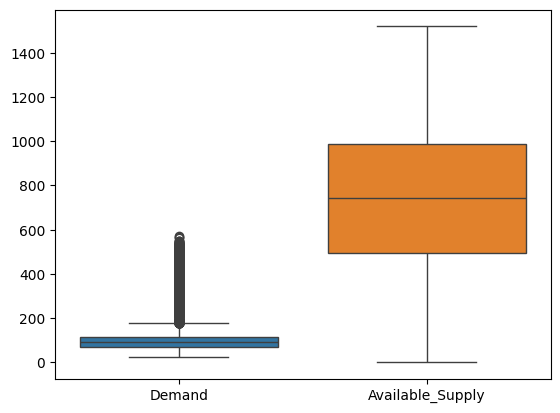

In [9]:
sns.boxplot(data=df[['Demand','Available_Supply']])

In [10]:
df.shape[0]

27405

In [11]:
# Since demand is heavily influenced by festivals, removing them means losing valueable information.
# Still removing the extreme outliers

lower_limit = df["Demand"].quantile(0.01)
upper_limit = df["Demand"].quantile(0.999)

print(upper_limit, lower_limit)

528.0 40.0


In [12]:
#cap outliers
df["Demand"] = np.where(
    df["Demand"] < lower_limit,
    lower_limit,
    np.where(df["Demand"] > upper_limit, upper_limit, df["Demand"])
)

Why capping instead of deletion?

-> ARIMA breaks if dates are removed<br>
-> Extreme spikes distort model parameters

Normalization -> no need in case of ARIMA

In [13]:
df.shape[0]

27405

### Sort data by time

In [14]:
# changing type of Date column to datetime
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [15]:
df.sort_values('Date', inplace=True)
df.reset_index(drop=True, inplace=True)

In [16]:
df.head()

,Date,Category,Product_Name,Demand,Available_Supply,Seasonal_Indicator
0,2021-01-01,Electronics,E001,76.0,744,0
1,2021-01-01,Sweets & Grocery,S005,129.0,971,0
2,2021-01-01,Sweets & Grocery,S003,107.0,903,0
3,2021-01-01,Electronics,E004,77.0,783,0
4,2021-01-01,Fashion,F005,56.0,494,0


In [17]:
df[['Demand','Available_Supply']].describe()

,Demand,Available_Supply
count,27405.000000,27405.000000
mean,119.090093,712.187630
std,94.308285,378.775936
min,40.000000,0.000000
25%,71.000000,495.000000
50%,92.000000,741.000000
75%,113.000000,987.000000
max,528.000000,1519.000000


## EDA

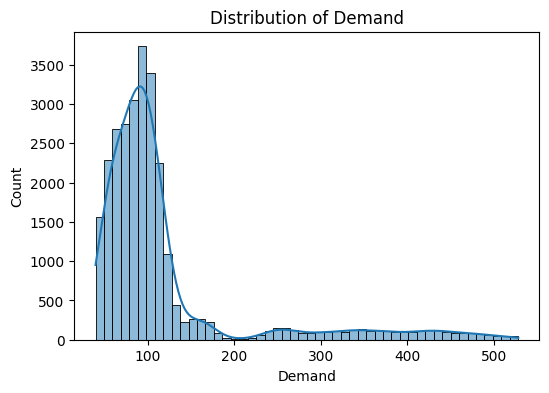

In [18]:
plt.figure(figsize=(6,4))
sns.histplot(df['Demand'], bins=50, kde=True)
plt.title("Distribution of Demand")
plt.show()

## Demand Forecasting Model (ARIMA)

### Using ARIMA

#### Product level

In [19]:
PRODUCT_COL = "Product_Name"
DEMAND_COL = "Demand"

product = df.groupby(PRODUCT_COL)[DEMAND_COL].sum().index[0]

# Selecting top-selling product
print("Training ARIMA model for product:", product)

Training ARIMA model for product: E001


In [20]:
time_series = df[df[PRODUCT_COL] == product][['Date', 'Demand']].set_index('Date').asfreq('D')


In [21]:
time_series=time_series.squeeze()

In [22]:
adf_stat, p_value, *_ = adfuller(time_series) #passing a series object

print("ADF Statistic:", adf_stat)
print("p-value:", p_value)

# Select differencing order
d = 0 if p_value < 0.05 else 1
print("Selected differencing order d =", d)


ADF Statistic: -6.020159655136453
p-value: 1.5004006764473188e-07
Selected differencing order d = 0


In [23]:
time_series_copy=time_series.copy()

In [24]:
# train-test split
time_series = time_series_copy[:-40]
FORECAST_HORIZON = 28
train = time_series[:-FORECAST_HORIZON]
test = time_series[-FORECAST_HORIZON:]

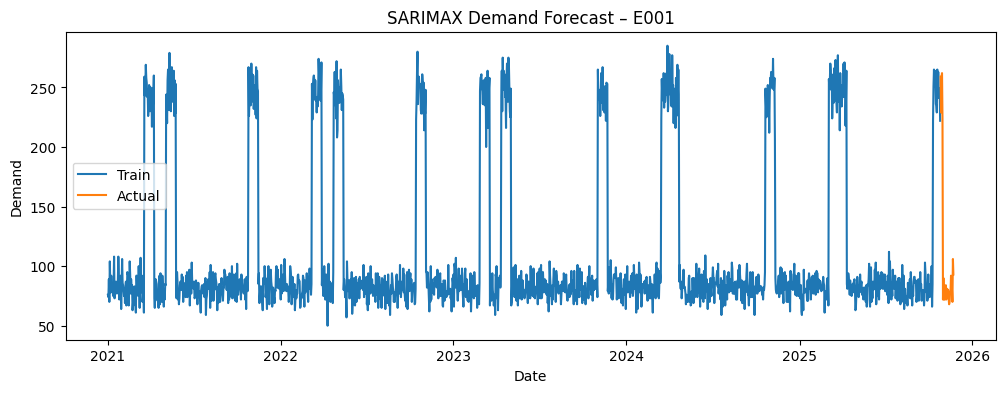

In [25]:
plt.figure(figsize=(12,4))
plt.plot(train, label="Train")
plt.plot(test, label="Actual")
plt.title(f"SARIMAX Demand Forecast – {product}")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.show()

In [26]:
# Training the model
model = SARIMAX(
    train,
    order=(1, d, 2),
    enforce_stationarity=False,
    enforce_invertibility=False
)
resultime_series = model.fit()

In [27]:
#forecast demand
forecast = resultime_series.get_forecast(steps=FORECAST_HORIZON)
forecasted_demand = forecast.predicted_mean

In [28]:
y_true = test
y_pred = forecasted_demand.loc[test.index]

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100
aic = resultime_series.aic

print("\nARIMA Model Performance")
print("----------------------")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"AIC  : {aic:.2f}")



ARIMA Model Performance
----------------------
MAE  : 92.76
RMSE : 99.32
MAPE : 115.23%
AIC  : 16180.39


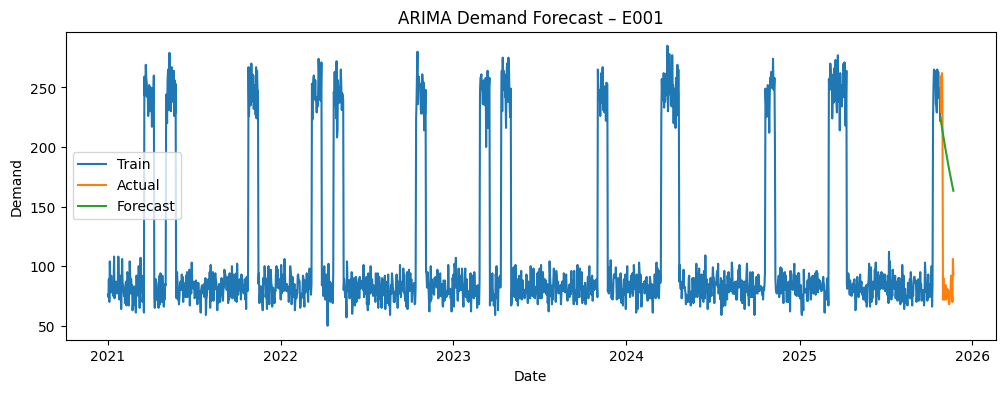

In [29]:
#forecast visualization
plt.figure(figsize=(12,4))
plt.plot(train, label="Train")
plt.plot(test, label="Actual")
plt.plot(forecasted_demand, label="Forecast")
plt.title(f"ARIMA Demand Forecast – {product}")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.show()


#### Category wise

In [30]:
CATEGORY_COL = "Category"
DEMAND_COL = "Demand"

category= df.groupby(CATEGORY_COL)[DEMAND_COL].sum().index[0]
print(category)

Electronics


In [31]:
category_df=df[df[CATEGORY_COL]==category].copy()

time_series = (
    category_df
    .groupby('Date')[DEMAND_COL]
    .sum()
    .resample("D")
    .sum()
    .fillna(0)
)

In [32]:
time_series

Date
2021-01-01    440.0
2021-01-02    478.0
2021-01-03    534.0
2021-01-04    469.0
2021-01-05    517.0
              ...  
2025-12-28    478.0
2025-12-29    502.0
2025-12-30    532.0
2025-12-31    508.0
2026-01-01    458.0
Freq: D, Name: Demand, Length: 1827, dtype: float64

In [33]:
adf_stat, p_value, *_ = adfuller(time_series) #passing a series object

print("ADF Statistic:", adf_stat)
print("p-value:", p_value)

# Select differencing order
d = 0 if p_value < 0.05 else 1
print("Selected differencing order d =", d)


ADF Statistic: -5.805850991802596
p-value: 4.51854723042223e-07
Selected differencing order d = 0


In [34]:
# train-test split
time_series = time_series[:-40]
FORECAST_HORIZON = 28
train = time_series[:-FORECAST_HORIZON]
test = time_series[-FORECAST_HORIZON:]

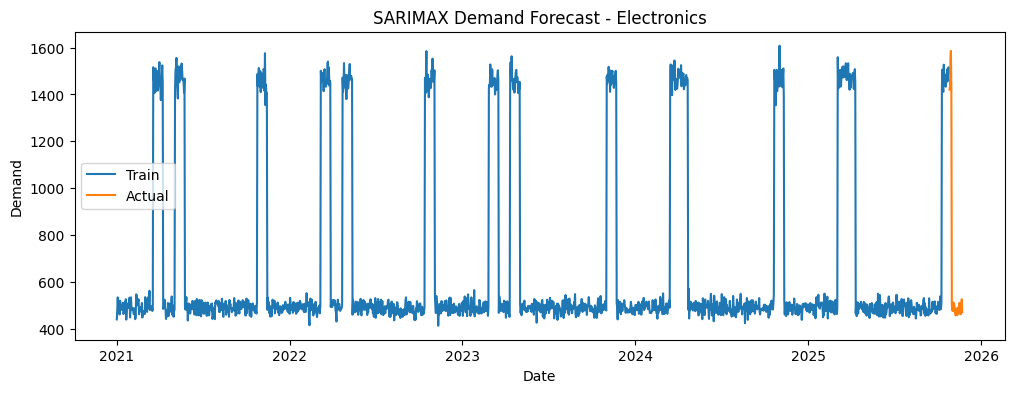

In [35]:
plt.figure(figsize=(12,4))
plt.plot(train, label="Train")
plt.plot(test, label="Actual")
plt.title(f"SARIMAX Demand Forecast - {category}")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.show()

In [36]:
# Training the model
model = SARIMAX(
    train,
    order=(1, d, 2),
    enforce_stationarity=False,
    enforce_invertibility=False
)
resultime_series = model.fit()

In [37]:
#forecast demand
forecast = resultime_series.get_forecast(steps=FORECAST_HORIZON)
forecasted_demand = forecast.predicted_mean

In [38]:
y_true = test
y_pred = forecasted_demand.loc[test.index]

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100
aic = resultime_series.aic

print("\nARIMA Model Performance")
print("----------------------")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"AIC  : {aic:.2f}")



ARIMA Model Performance
----------------------
MAE  : 627.28
RMSE : 685.10
MAPE : 128.00%
AIC  : 21846.26


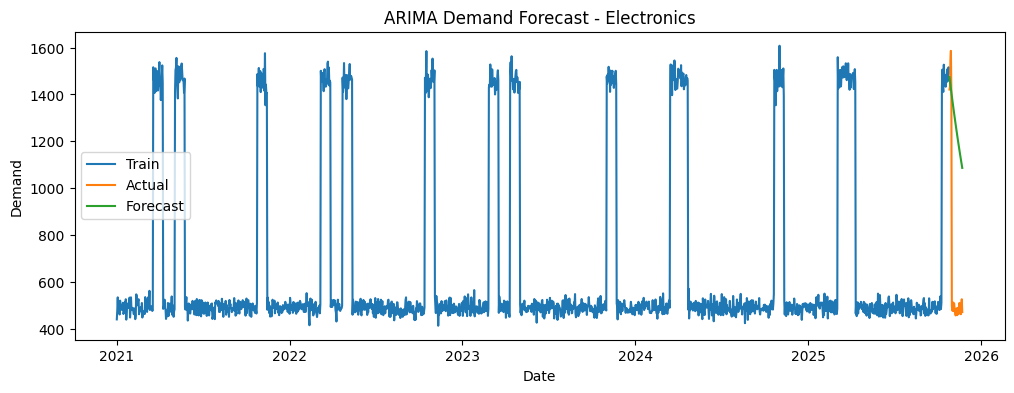

In [39]:
#forecast visualization
plt.figure(figsize=(12,4))
plt.plot(train, label="Train")
plt.plot(test, label="Actual")
plt.plot(forecasted_demand, label="Forecast")
plt.title(f"ARIMA Demand Forecast - {category}")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.show()


### Using SARIMA

#### Product wise

In [40]:
# using sarimax
PRODUCT_COL = "Product_Name"
DEMAND_COL = "Demand"
EXOG_COL = "Seasonal_Indicator"

product = (
    df.groupby(PRODUCT_COL)[DEMAND_COL]
    .sum()
    .sort_values(ascending=False)
    .index[0]
)

print("Training SARIMAX model for product:", product)

Training SARIMAX model for product: S005


In [41]:
product_df = df[df[PRODUCT_COL] == product].copy()

time_series = (
    product_df
    .set_index("Date")[DEMAND_COL]
    .resample("D")
    .sum()
    .fillna(0)
)

#exogeneous variable -> 
exog = (
    product_df
    .set_index("Date")[EXOG_COL]
    .resample("D")
    .max()        
    .fillna(0)
)

time_series = time_series.asfreq("D")
exog = exog.asfreq("D")


In [42]:

adf_stat, p_value, *_ = adfuller(time_series)

d = 0 if p_value < 0.05 else 1
print("ADF p-value:", p_value)
print("Selected differencing order d =", d)


ADF p-value: 3.730171032168166e-07
Selected differencing order d = 0


In [43]:
FORECAST_HORIZON = 28
time_series=time_series[:-50]
exog=exog[:-50]

train_y = time_series[:-FORECAST_HORIZON]
test_y = time_series[-FORECAST_HORIZON:]

train_exog = exog[:-FORECAST_HORIZON]
test_exog = exog[-FORECAST_HORIZON:]


In [44]:
model = SARIMAX(
    train_y,
    exog=train_exog,
    order=(1, d, 2),
    seasonal_order=(1, 0, 1, 7),  # weekly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)

resultime_series = model.fit()
print(resultime_series.summary())


                                      SARIMAX Results                                      
Dep. Variable:                              Demand   No. Observations:                 1749
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 7)   Log Likelihood               -6924.705
Date:                             Tue, 20 Jan 2026   AIC                          13863.409
Time:                                     15:23:26   BIC                          13901.637
Sample:                                 01-01-2021   HQIC                         13877.545
                                      - 10-15-2025                                         
Covariance Type:                               opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Seasonal_Indicator   387.1328      0.799    484.341      0.000     385.566     388.699
ar.

In [45]:
forecast = resultime_series.get_forecast(
    steps=FORECAST_HORIZON,
    exog=test_exog
)

forecasted_demand = forecast.predicted_mean


In [46]:
mae = mean_absolute_error(test_y, forecasted_demand)
rmse = np.sqrt(mean_squared_error(test_y, forecasted_demand))
mape = np.mean(np.abs((test_y - forecasted_demand) / (test_y + 1e-9))) * 100
aic = resultime_series.aic

print("\nSARIMAX Model Performance")
print("------------------------")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"AIC  : {aic:.2f}")



SARIMAX Model Performance
------------------------
MAE  : 17.72
RMSE : 21.83
MAPE : 7.73%
AIC  : 13863.41


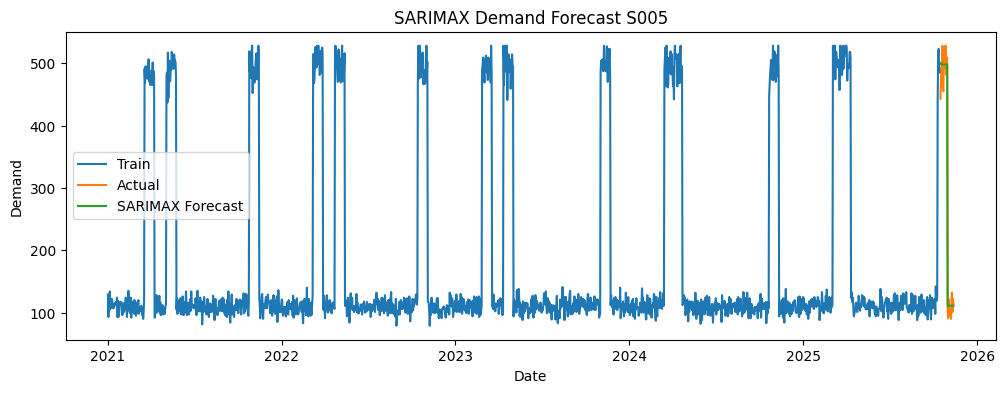

In [47]:
plt.figure(figsize=(12,4))
plt.plot(train_y, label="Train")
plt.plot(test_y, label="Actual")
plt.plot(forecasted_demand, label="SARIMAX Forecast")
plt.title(f"SARIMAX Demand Forecast {product}")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.show()


#### Category wise

In [48]:
CATEGORY_COL = "Category"
DEMAND_COL = "Demand"
EXOG_COL = "Seasonal_Indicator"

category= df.groupby(CATEGORY_COL)[DEMAND_COL].sum().index[0]
print(category)

Electronics


In [49]:
category_df=df[df[CATEGORY_COL]==category].copy()

time_series = (
    category_df
    .groupby('Date')[DEMAND_COL]
    .sum()
    .resample("D")
    .sum()
)

exog = (
    category_df
    .groupby('Date')[EXOG_COL]
    .max()
    .resample("D")
    .max()
)

time_series = time_series.asfreq("D")
exog = exog.asfreq("D")

In [50]:

adf_stat, p_value, *_ = adfuller(time_series)

d = 0 if p_value < 0.05 else 1
print("ADF p-value:", p_value)
print("Selected differencing order d =", d)


ADF p-value: 4.51854723042223e-07
Selected differencing order d = 0


In [51]:
FORECAST_HORIZON = 28
time_series=time_series[:-50]
exog=exog[:-50]

train_y = time_series[:-FORECAST_HORIZON]
test_y = time_series[-FORECAST_HORIZON:]

train_exog = exog[:-FORECAST_HORIZON]
test_exog = exog[-FORECAST_HORIZON:]


In [52]:
model = SARIMAX(
    train_y,
    exog=train_exog,
    order=(1, d, 2),
    seasonal_order=(1, 0, 1, 7),  # weekly seasonality
    enforce_stationarity=False,
    enforce_invertibility=False
)

resultime_series = model.fit()
print(resultime_series.summary())


                                      SARIMAX Results                                      
Dep. Variable:                              Demand   No. Observations:                 1749
Model:             SARIMAX(1, 0, 2)x(1, 0, [1], 7)   Log Likelihood               -9448.219
Date:                             Tue, 20 Jan 2026   AIC                          18910.438
Time:                                     15:23:28   BIC                          18948.666
Sample:                                 01-01-2021   HQIC                         18924.574
                                      - 10-15-2025                                         
Covariance Type:                               opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Seasonal_Indicator  1278.9445      4.416    289.619      0.000    1270.289    1287.600
ar.

In [53]:
forecast = resultime_series.get_forecast(
    steps=FORECAST_HORIZON,
    exog=test_exog
)

forecasted_demand = forecast.predicted_mean


In [54]:
mae = mean_absolute_error(test_y, forecasted_demand)
rmse = np.sqrt(mean_squared_error(test_y, forecasted_demand))
mape = np.mean(np.abs((test_y - forecasted_demand) / (test_y + 1e-9))) * 100
aic = resultime_series.aic

print("\nSARIMAX Model Performance")
print("------------------------")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"MAPE : {mape:.2f}%")
print(f"AIC  : {aic:.2f}")



SARIMAX Model Performance
------------------------
MAE  : 159.69
RMSE : 208.36
MAPE : 30.19%
AIC  : 18910.44


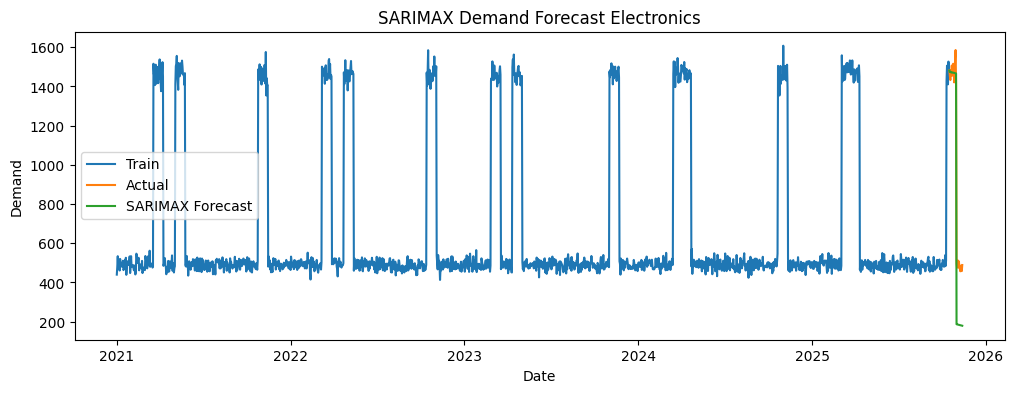

In [55]:
plt.figure(figsize=(12,4))
plt.plot(train_y, label="Train")
plt.plot(test_y, label="Actual")
plt.plot(forecasted_demand, label="SARIMAX Forecast")
plt.title(f"SARIMAX Demand Forecast {category}")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.legend()
plt.show()


### Creating multiple models for product and categories

#### Products

In [56]:
import json
import os

def log_model_performance(model,product_name, category, mae, rmse, mape, aic, log_file):
    
    # log_file="../outputs/performance_logs.json"
    
    entry = {
        "model": model,
        "name": product_name,
        "category": category,
        "metrics": {
            "MAE": mae,
            "RMSE": rmse,
            "MAPE": mape,
            "AIC": aic
        }
    }

    
    if os.path.exists(log_file):
        with open(log_file, 'r') as file:
            data = json.load(file)
    else:
        data = []
    
    data.append(entry)
    
    with open(log_file, 'w') as file:
        json.dump(data, file, indent=4)

In [57]:
def train_and_save_arima_model_by_product(product_name):
    product_df = df[df[PRODUCT_COL] == product_name].copy()
    
    #time series
    time_series = (
        product_df
        .set_index("Date")[DEMAND_COL]
        .resample("D")
        .sum()
    )

    adf_stat, p_value, *_ = adfuller(time_series) #passing a series object

    # print("ADF Statistic:", adf_stat)
    # print("p-value:", p_value)

    # Select differencing order

    d = 0 if p_value < 0.05 else 1
    # print("Selected differencing order d =", d)

    # train-test split
    time_series = time_series[:-40]
    FORECAST_HORIZON = 28
    train = time_series[:-FORECAST_HORIZON]
    test = time_series[-FORECAST_HORIZON:]

    # Fit ARIMA model
    model = SARIMAX(
        train,
        order=(1, d, 2),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    resultime_series = model.fit()

    # Save the model
    with open(f'../models/ARIMA/Product/{product_name}_arima_model.pkl', 'wb') as f:
        pickle.dump(resultime_series, f)

    #forecast demand for prediction and evaluation metrics
    forecast = resultime_series.get_forecast(steps=FORECAST_HORIZON)
    forecasted_demand = forecast.predicted_mean

    

    y_true = test
    y_pred = forecasted_demand.loc[test.index]

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100
    aic = resultime_series.aic

    # print("\nARIMA Model Performance")
    # print("----------------------")
    # print(f"MAE  : {mae:.2f}")
    # print(f"RMSE : {rmse:.2f}")
    # print(f"MAPE : {mape:.2f}%")
    # print(f"AIC  : {aic:.2f}")

    log_model_performance("arima",product_name, None,mae, rmse, mape, aic, log_file="../outputs/arima_performance_logs.json")

    #forecast visualization
    plt.figure(figsize=(12,4))
    plt.plot(train, label="Train")
    plt.plot(test, label="Actual")
    plt.plot(forecasted_demand, label="Forecast")
    plt.title(f"ARIMA Demand Forecast {product_name}")
    plt.xlabel("Date")
    plt.ylabel("Demand")
    plt.legend()
    plt.savefig(f"../outputs/ARIMA/Product/{product_name}_ARIMA_Forecast.png")
    plt.close()

    return  
    
    

In [58]:
def train_and_save_sarima_model_by_product(product_name):
    product_df = df[df[PRODUCT_COL] == product_name].copy()
    
    #time series
    time_series = (
        product_df
        .set_index("Date")[DEMAND_COL]
        .resample("D")
        .sum()
    )

    # exogenous variable
    exog = (
        product_df
        .set_index("Date")[ "Seasonal_Indicator"]
        .resample("D")
        .sum()
    )

    time_series = time_series.asfreq("D")
    exog = exog.asfreq("D")

    adf_stat, p_value, *_ = adfuller(time_series) #passing a series object

    # print("ADF Statistic:", adf_stat)
    # print("p-value:", p_value)

    # Select differencing order

    d = 0 if p_value < 0.05 else 1
    # print("Selected differencing order d =", d)

    # train-test split
    time_series = time_series[:-40]
    exog=exog[:-40]
    
    FORECAST_HORIZON = 28
    train = time_series[:-FORECAST_HORIZON]
    test = time_series[-FORECAST_HORIZON:]

    train_exog = exog[:-FORECAST_HORIZON]
    test_exog = exog[-FORECAST_HORIZON:]

    # Fit ARIMA model
    model = SARIMAX(
        train,
        exog=train_exog,
        order=(1, d, 2),
        seasonal_order=(1, 0, 1, 7),  # weekly seasonality
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    resultime_series = model.fit()

    # Save the model
    with open(f'../models/SARIMA/Product/{product_name}_sarima_model.pkl', 'wb') as f:
        pickle.dump(resultime_series, f)

    #forecast demand for prediction and evaluation metrics
    forecast = resultime_series.get_forecast(
        steps=FORECAST_HORIZON,
        exog=test_exog
    )

    forecasted_demand = forecast.predicted_mean

    

    y_true = test
    y_pred = forecasted_demand.loc[test.index]

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100
    aic = resultime_series.aic

    # print("\nARIMA Model Performance")
    # print("----------------------")
    # print(f"MAE  : {mae:.2f}")
    # print(f"RMSE : {rmse:.2f}")
    # print(f"MAPE : {mape:.2f}%")
    # print(f"AIC  : {aic:.2f}")

    log_model_performance("sarima",product_name, None, mae, rmse, mape, aic, log_file="../outputs/sarima_performance_logs.json")

    #forecast visualization
    plt.figure(figsize=(12,4))
    plt.plot(train, label="Train")
    plt.plot(test, label="Actual")
    plt.plot(forecasted_demand, label="Forecast")
    plt.title(f"SARIMA Demand Forecast {product_name}")
    plt.xlabel("Date")
    plt.ylabel("Demand")
    plt.legend()
    plt.savefig(f"../outputs/SARIMA/Product/{product_name}_SARIMA_Forecast.png")
    plt.close()

    return  

In [59]:
# training multiple models for different products

products = df.groupby(PRODUCT_COL)[DEMAND_COL].sum()

for product_name in products.index:
    train_and_save_arima_model_by_product(product_name)
    train_and_save_sarima_model_by_product(product_name)

#### Category


In [60]:
def train_and_save_arima_model_by_category(category_name):
    category_df=df[df[CATEGORY_COL]==category_name].copy()

    time_series = (
        category_df
        .groupby('Date')[DEMAND_COL]
        .sum()
        .resample("D")
        .sum()
        .fillna(0)
    )

    adf_stat, p_value, *_ = adfuller(time_series) #passing a series object

    # print("ADF Statistic:", adf_stat)
    # print("p-value:", p_value)

    # Select differencing order

    d = 0 if p_value < 0.05 else 1
    # print("Selected differencing order d =", d)

    # train-test split
    time_series = time_series[:-40]
    FORECAST_HORIZON = 28
    train = time_series[:-FORECAST_HORIZON]
    test = time_series[-FORECAST_HORIZON:]

    # Fit ARIMA model
    model = SARIMAX(
        train,
        order=(1, d, 2),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    resultime_series = model.fit()

    # Save the model
    with open(f'../models/ARIMA/Category/{category_name}_arima_model.pkl', 'wb') as f:
        pickle.dump(resultime_series, f)

    #forecast demand for prediction and evaluation metrics
    forecast = resultime_series.get_forecast(steps=FORECAST_HORIZON)
    forecasted_demand = forecast.predicted_mean

    

    y_true = test
    y_pred = forecasted_demand.loc[test.index]

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100
    aic = resultime_series.aic

    # print("\nARIMA Model Performance")
    # print("----------------------")
    # print(f"MAE  : {mae:.2f}")
    # print(f"RMSE : {rmse:.2f}")
    # print(f"MAPE : {mape:.2f}%")
    # print(f"AIC  : {aic:.2f}")

    log_model_performance("arima", None, category_name, mae, rmse, mape, aic, log_file="../outputs/arima_performance_logs.json")

    #forecast visualization
    plt.figure(figsize=(12,4))
    plt.plot(train, label="Train")
    plt.plot(test, label="Actual")
    plt.plot(forecasted_demand, label="Forecast")
    plt.title(f"ARIMA Demand Forecast {category_name}")
    plt.xlabel("Date")
    plt.ylabel("Demand")
    plt.legend()
    plt.savefig(f"../outputs/ARIMA/Category/{category_name}_ARIMA_Forecast.png")
    plt.close()

    return
    
    

In [61]:
def train_and_save_sarima_model_by_category(category_name):
    category_df = df[df[CATEGORY_COL] == category_name].copy()
    
    #time series
    time_series = (
        category_df
        .groupby('Date')[DEMAND_COL]
        .sum()
        .resample("D")
        .sum()
    )

    exog = (
        category_df
        .groupby('Date')[EXOG_COL]
        .max()
        .resample("D")
        .max()
    )

    time_series = time_series.asfreq("D")
    exog = exog.asfreq("D")

    adf_stat, p_value, *_ = adfuller(time_series) #passing a series object

    # print("ADF Statistic:", adf_stat)
    # print("p-value:", p_value)

    # Select differencing order

    d = 0 if p_value < 0.05 else 1
    # print("Selected differencing order d =", d)

    # train-test split
    time_series = time_series[:-40]
    exog=exog[:-40]
    
    FORECAST_HORIZON = 28
    train = time_series[:-FORECAST_HORIZON]
    test = time_series[-FORECAST_HORIZON:]

    train_exog = exog[:-FORECAST_HORIZON]
    test_exog = exog[-FORECAST_HORIZON:]

    # Fit ARIMA model
    model = SARIMAX(
        train,
        exog=train_exog,
        order=(1, d, 2),
        seasonal_order=(1, 0, 1, 7),  # weekly seasonality
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    resultime_series = model.fit()

    # Save the model
    with open(f'../models/SARIMA/Category/{category_name}_sarima_model.pkl', 'wb') as f:
        pickle.dump(resultime_series, f)

    #forecast demand for prediction and evaluation metrics
    forecast = resultime_series.get_forecast(
        steps=FORECAST_HORIZON,
        exog=test_exog
    )

    forecasted_demand = forecast.predicted_mean

    

    y_true = test
    y_pred = forecasted_demand.loc[test.index]

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100
    aic = resultime_series.aic


    log_model_performance("sarima",None, category_name, mae, rmse, mape, aic, log_file="../outputs/sarima_performance_logs.json")

    #forecast visualization
    plt.figure(figsize=(12,4))
    plt.plot(train, label="Train")
    plt.plot(test, label="Actual")
    plt.plot(forecasted_demand, label="Forecast")
    plt.title(f"SARIMA Demand Forecast {category_name}")
    plt.xlabel("Date")
    plt.ylabel("Demand")
    plt.legend()
    plt.savefig(f"../outputs/SARIMA/Category/{category_name}_SARIMA_Forecast.png")
    plt.close()

    return  

In [62]:
# training multiple models for different categories

category = df[CATEGORY_COL].unique().tolist()

for category_name in category:
    train_and_save_arima_model_by_category(category_name)
    train_and_save_sarima_model_by_category(category_name)